Two input files: 

- CDR BED files 

- Centromere annotation files 


We want to get stats on CDRs which is where the centromere annotation track overlaps with the strict CDR bed files

(1) start and end of the total CDR in the array 

(2) the size and spacing of the internal components, or collection of CDRs 


# Imports

In [305]:
# imports
import os
import seaborn as sns
import matplotlib as plt
import pandas as pd
import numpy as np
from natsort import index_natsorted, order_by_index
sns.set()  # Don't forget this!
from matplotlib import pyplot

%matplotlib inline
import argparse

# CDR objects

In [306]:
class CDR:
    def __init__(self, numChr, hap, start, end) -> None:
        '''
        Class for each unique overlap (centromere dip region) for each chromosome
        '''
        self.numChr = numChr
        self.hap = hap
        self.start = int(start)  # convert to int, otherwise returns Nonetype error
        self.end = int(end)

# Parsing through BED files of intersected regions

In [307]:
# parsing the overlapping regions bedfiles

def bedParse(dir):
    """
    bedParse takes in a file path of a folder of bedfiles outputted from bedtools intersect
    and stores all the information into a list of CDR objects.
    Returns a list of CDR objects. 
    """
    # store all unique overlaps as individual CDR objects
    cdr_list = []
    for root, dirs, files in os.walk(dir): # open folder intersectOutputs
        for filename in files:  # iterate through each file in the folder
            filepath = os.path.join(root, filename)  # file path
            filename_split = filename.split('_')
            if filename != '.DS_Store' and filename[6:10] != 'acro' and filename_split[1][:4] != 'chrM' and filename_split[1][:6] != 'chrEBV':  # dont read in the .DS_store file
                with open(filepath) as f:  # now we are in the file
                    lines = f.readlines()
                    uniques = set()
                    allCDRs = []
                    for line in lines: # for each line of overlaps in the file
                        col = line.split()
                        start, end = col[1], col[2]  # 2nd, 3rd column
                        uniques.add((start,end))
                        allCDRs.append((start, end))
                    # filename_split = filename.split('_')
                    # for tup in uniques:
                    for tup in allCDRs:
                        if filename_split[0][2:].isalpha():  # if the chromosome is X or Y (after chr)
                            cdr = CDR(filename_split[0][2:], filename_split[1], tup[0], tup[1])
                        else:  # if the chromosome is a number then store the chromosome num as an int
                            cdr = CDR(int(filename_split[0][2:]), filename_split[1], tup[0], tup[1])
                        cdr_list.append(cdr)
    return cdr_list

directory = '/Users/emilyxu/Desktop/cdrproject/intersectOutputs'
cdr_list = bedParse(directory)

directory = '/Users/emilyxu/Desktop/cdrproject/filteredIntersectOutputs'
filteredCDR = bedParse(directory)



# Parsing through HMM predicted BED files

In [308]:
# For Justin's HMM bedfiles - stores the CDRs in a list

def bedParse(dir):
    """
    bedParse takes in a file folder of bedfiles outputted from bedtools intersect
    and stores all the information into a list of CDR objects.
    Returns a list of CDR objects. 
    """
    # store all unique overlaps as individual CDR objects
    cdr_list = []
    for root, dirs, files in os.walk(dir): # open folder intersectOutputs
        for filename in files:  # iterate through each file in the folder
            filepath = os.path.join(root, filename)  # file path
            filename_split = filename.split('_')
            if filename != '.DS_Store' and filename[6:10] != 'acro' and filename_split[1][:4] != 'chrM' and filename_split[1][:6] != 'chrEBV':  # dont read in the .DS_store file
                with open(filepath) as f:  # now we are in the file
                    lines = f.readlines()
                    uniques = set()
                    allCDRs = []
                    for line in lines: # for each line of overlaps in the file
                        col = line.split()
                        start, end = col[1], col[2]  # 2nd, 3rd column
                        uniques.add((start,end))
                        allCDRs.append((start, end))
                    # filename_split = filename.split('_')
                    # for tup in uniques:
                    for tup in allCDRs:
                        # print(filename_split[1][3:], filename_split[2][:8])
                        if filename_split[1][3:].isalpha():  # if the chromosome is X or Y (after chr)
                            cdr = CDR(filename_split[1][3:], filename_split[2][:8], tup[0], tup[1])
                        else:  # if the chromosome is a number then store the chromosome num as an int
                            cdr = CDR(int(filename_split[1][3:]), filename_split[2][:8], tup[0], tup[1])
                        cdr_list.append(cdr)
    return cdr_list

directory = '/Users/emilyxu/Desktop/cdrproject/HMMBedData'
hmmList = bedParse(directory)

# Parsing through strict BED files (all chromosomes)

In [309]:
# strict bedfiles parsing and storing them into a dataframe
directory = '/Users/emilyxu/Desktop/cdrproject/CDRStrictBedFiles'

strictBed = []
for root, dirs, files in os.walk(directory): # open folder intersectOutputs
    for filename in files:  # iterate through each file in the folder
        filepath = os.path.join(root, filename)  # file path
        filename_split = filename.split('_')
        if filename != '.DS_Store' and filename[6:10] != 'acro' and filename_split[1][:4] != 'chrM' and filename_split[1][:6] != 'chrEBV':  # dont read in certain files
            with open(filepath) as f:  # now we are in the file
                strictBed.append((filename_split[1][3:], filename_split[2][:8], len(f.readlines())))

strictBedDF = pd.DataFrame(strictBed, columns=['ChrmNum','haplotype', 'length'])  # length = lines in the file (num of hypomethylated regions, not necessarily all CDRs)
strictBedDF['haplotype'] = strictBedDF['haplotype'].str.lower()
strictBedDF = strictBedDF.reindex(index=order_by_index(strictBedDF.index, index_natsorted(strictBedDF['ChrmNum'], reverse=False)))


# Data Exploration

## Over all chromosomes

In [310]:
# 1. (strict BED files) summary of lengths of CDRs across all chromosomes 
#    boxplot or histogram 

# all CDR ranges in one dataframe
# chr#     start       end
# chr6   43824280    49285928
# chr6    3948239    3949240

allDF = pd.DataFrame([(cdr.numChr, (cdr.start, cdr.end), cdr.hap) for cdr in cdr_list], 
                    columns=['ChrmNum','ranges', 'haplotype'])

# sort df by chromosome number
allDF = allDF.reindex(index=order_by_index(allDF.index, index_natsorted(allDF['ChrmNum'], reverse=False)))
allDF['start'], allDF['end'] = allDF.ranges.str
allDF['length'] = allDF['end'] - allDF['start']
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # print entire dataframe out
#     print(df)
print(allDF)

# sort uniques
uniques = allDF.groupby('ranges').first().reset_index()
uniques = uniques.reindex(index=order_by_index(uniques.index, index_natsorted(uniques['ChrmNum'], reverse=False)))
uniques = uniques[['ChrmNum', 'ranges', 'haplotype', 'start', 'end', 'length']]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # print entire dataframe out
    print(len(uniques))


      ChrmNum                  ranges haplotype      start        end  length
5302        1  (124421626, 124444626)  paternal  124421626  124444626   23000
5303        1  (124421626, 124444626)  paternal  124421626  124444626   23000
5304        1  (124421626, 124444626)  paternal  124421626  124444626   23000
5305        1  (124421626, 124444626)  paternal  124421626  124444626   23000
5306        1  (124421626, 124444626)  paternal  124421626  124444626   23000
...       ...                     ...       ...        ...        ...     ...
29319       Y    (19142688, 19146688)  paternal   19142688   19146688    4000
29320       Y    (19142688, 19146688)  paternal   19142688   19146688    4000
29321       Y    (19142688, 19146688)  paternal   19142688   19146688    4000
29322       Y    (19142688, 19146688)  paternal   19142688   19146688    4000
29323       Y    (19142688, 19146688)  paternal   19142688   19146688    4000

[50318 rows x 6 columns]
1435


/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


## Storing list of HMM predicted CDRs in a dataframe

In [311]:
# HMM dataframe

allHMM = pd.DataFrame([(cdr.numChr, (cdr.start, cdr.end), cdr.hap) for cdr in hmmList], 
                    columns=['ChrmNum','ranges', 'haplotype'])

# sort df by chromosome number
allHMM = allHMM.reindex(index=order_by_index(allHMM.index, index_natsorted(allHMM['ChrmNum'], reverse=False)))
allHMM['start'], allHMM['end'] = allHMM.ranges.str
allHMM['length'] = allHMM['end'] - allHMM['start']
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # print entire dataframe out
#     print(df)

# sort uniques
uniqueHMM = allHMM.groupby('ranges').first().reset_index()
uniqueHMM = uniqueHMM.reindex(index=order_by_index(uniqueHMM.index, index_natsorted(uniqueHMM['ChrmNum'], reverse=False)))
uniqueHMM = uniqueHMM[['ChrmNum', 'ranges', 'haplotype', 'start', 'end', 'length']]

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # print entire dataframe out
#     print(allDF)

display(uniqueHMM)

/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


,ChrmNum,ranges,haplotype,start,end,length
623,1,"(122588553, 122607144)",MATERNAL,122588553,122607144,18591
624,1,"(122608264, 122609774)",MATERNAL,122608264,122609774,1510
625,1,"(122610340, 122652509)",MATERNAL,122610340,122652509,42169
626,1,"(122670602, 122671622)",MATERNAL,122670602,122671622,1020
627,1,"(122674913, 122686663)",MATERNAL,122674913,122686663,11750
...,...,...,...,...,...,...
158,Y,"(10626325, 10670407)",PATERNAL,10626325,10670407,44082
159,Y,"(10688835, 10690137)",PATERNAL,10688835,10690137,1302
160,Y,"(10724670, 10732249)",PATERNAL,10724670,10732249,7579
161,Y,"(10736240, 10772184)",PATERNAL,10736240,10772184,35944


## Statistical Questions: 
1. How many times does each duplicate occur?

In [312]:
# statistical questions: 
# 1. How many times does each duplicate occur?
# Format:
#                                   numOcc
# Chr 1: (124421626, 124444626):     16
# Chr 1: (124421626, 147348134):     25

counts = allDF.groupby(allDF.columns.tolist(),as_index=False).size()
counts = counts.reindex(index=order_by_index(counts.index, index_natsorted(counts['ChrmNum'], reverse=False)))
counts['overlap occurrences'] = counts['size']
display(counts[['ChrmNum', 'ranges','haplotype','overlap occurrences']])

# barplot
# fig, axes = pyplot.subplots(3,1, figsize=(16,15))

# sns.barplot(ax=axes[0], data=counts, x="ChrmNum", y="overlap occurrences").set_title('All Chromosomes')

# counts_mat = counts.loc[counts['haplotype'] == 'maternal']
# sns.barplot(ax=axes[1],data= counts_mat, x="ChrmNum", y="overlap occurrences").set_title('Maternal Chromosomes')

# counts_pat = counts.loc[counts['haplotype'] == 'paternal']
# sns.barplot(ax=axes[2],data= counts_pat, x="ChrmNum", y="overlap occurrences").set_title('Paternal Chromosomes')

,ChrmNum,ranges,haplotype,overlap occurrences
0,1,"(122587375, 122609375)",maternal,130
1,1,"(122610375, 122652375)",maternal,248
2,1,"(122670375, 122687375)",maternal,101
3,1,"(122778375, 122788375)",maternal,59
4,1,"(122830375, 122838375)",maternal,48
...,...,...,...,...
1430,Y,"(18583688, 18589688)",paternal,34
1431,Y,"(19126688, 19129688)",paternal,7
1432,Y,"(19130688, 19133688)",paternal,19
1433,Y,"(19138688, 19141688)",paternal,15


2. What is the percentage of overlaps vs non overlaps? 

In [313]:
# 2. What is the percentage of overlaps vs non overlaps? 
# --> compare strict bedfiles with intersect bedfiles (uniques)

total = counts.groupby(['ChrmNum', 'haplotype'])['overlap occurrences'].sum()
total = total.reset_index()
total['Chrm'] = total['ChrmNum'].astype(str) + '_' + total['haplotype']

strictBedDF = strictBedDF.reset_index(drop=True)
strictBedDF['Chrm'] = strictBedDF['ChrmNum'].astype(str) + '_' + strictBedDF['haplotype']

merged = strictBedDF.merge(total, how='outer', on='Chrm')
merged[['Chrm', 'length', 'overlap occurrences']]
merged['percent of overlaps'] = (merged['overlap occurrences'] / merged['length']) * 100
merged['percent of non-overlaps'] = ((merged['length'] - merged['overlap occurrences']) / merged['length']) * 100
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # print entire dataframe out
#     print(merged)
display(merged)

,ChrmNum_x,haplotype_x,length,Chrm,ChrmNum_y,haplotype_y,overlap occurrences,percent of overlaps,percent of non-overlaps
0,1,paternal,2863,1_paternal,1,paternal,749,26.161369,73.838631
1,1,maternal,3007,1_maternal,1,maternal,604,20.086465,79.913535
2,2,paternal,2896,2_paternal,2,paternal,682,23.549724,76.450276
3,2,maternal,2940,2_maternal,2,maternal,666,22.653061,77.346939
4,3,paternal,2646,3_paternal,3,paternal,474,17.913832,82.086168
5,3,maternal,2953,3_maternal,3,maternal,594,20.115137,79.884863
6,4,paternal,3367,4_paternal,4,paternal,538,15.978616,84.021384
7,4,maternal,2881,4_maternal,4,maternal,449,15.584866,84.415134
8,5,paternal,2595,5_paternal,5,paternal,986,37.996146,62.003854
9,5,maternal,2712,5_maternal,5,maternal,839,30.936578,69.063422


## Histogram of the CDR locations

/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'Frequency')

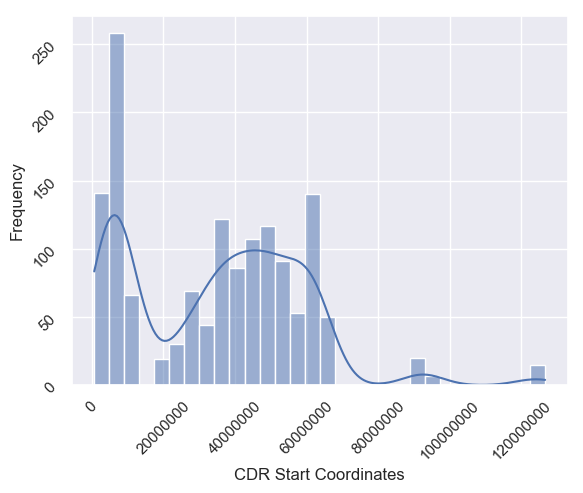

In [314]:
# position of CDR regions

plot = sns.histplot(data=uniques.start, bins=30, kde=True) # plot histogram
plot.ticklabel_format(style='plain', axis='x',useOffset=False)  # get rid of scientific notation values
plot.tick_params(labelrotation=45)  # rotate x ticks
plot.set_xlabel('CDR Start Coordinates')
plot.set_ylabel('Frequency')

## Histogram for length of CDRs

/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(0, 17500)

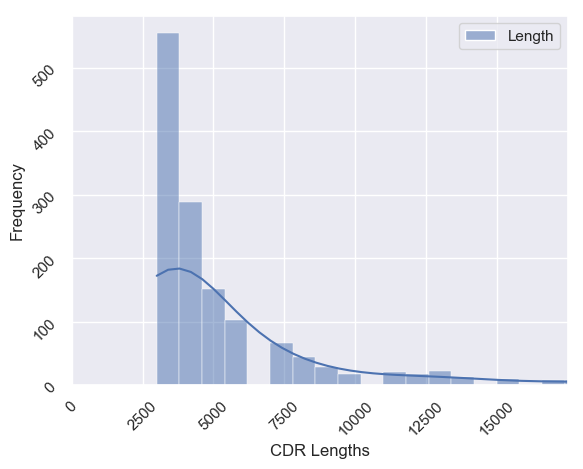

In [315]:
# histogram for length of CDR regions
df = pd.DataFrame([(cdr.numChr, cdr.start, cdr.end, cdr.hap) for cdr in cdr_list], 
                    columns=['ChrmNum','start', 'end', 'haplotype'])

lengthDf = pd.DataFrame(uniques.end-uniques.start, columns=['Length'])
lengthDf

# plot length graph
plot = sns.histplot(data=lengthDf, bins=100, kde=True) # plot histogram
plot.ticklabel_format(style='plain', axis='x',useOffset=False)  # get rid of scientific notation values
plot.tick_params(labelrotation=45)  # rotate x ticks
plot.set_xlabel('CDR Lengths')
plot.set_ylabel('Frequency')
plot.set_xticks(np.arange(0, 17500, 2500))
plot.set_xticklabels(plot.get_xticks(), rotation=45)
plot.set_xlim(0,17500)

# calculate mean, median, range for lengths, remove outliers
# use just one chromosome X as an example

# Summary Statistics on CDR Lengths

In [316]:
# summary stats on CDR lengths
summary = uniques.describe()
correlations = uniques.corr()
stdError = uniques.std()

print('Summary of all CDRs (with outliers): \n', summary)
print()
print('Summary of maternal CDRs (with outliers): \n', (uniques.loc[uniques['haplotype'] == 'maternal']).describe())
print()
print('Summary of paternal CDRs (with outliers): \n', (uniques.loc[uniques['haplotype'] == 'paternal']).describe())

# mean
# range
# median
# max, min
# filter out some outliers

Summary of all CDRs (with outliers): 
               start           end        length
count  1.435000e+03  1.435000e+03   1435.000000
mean   3.483213e+07  3.483854e+07   6417.421603
std    2.422208e+07  2.422274e+07   7055.022073
min    7.105410e+05  7.135410e+05   3000.000000
25%    8.403616e+06  8.411116e+06   3000.000000
50%    3.796064e+07  3.796364e+07   4000.000000
75%    5.151988e+07  5.152788e+07   6000.000000
max    1.266314e+08  1.266344e+08  83000.000000

Summary of maternal CDRs (with outliers): 
               start           end        length
count  6.840000e+02  6.840000e+02    684.000000
mean   3.622709e+07  3.623343e+07   6343.567251
std    2.391788e+07  2.391865e+07   6588.985629
min    1.860539e+06  1.864539e+06   3000.000000
25%    1.010163e+07  1.010788e+07   3000.000000
50%    3.864114e+07  3.864564e+07   4000.000000
75%    5.492880e+07  5.493455e+07   6000.000000
max    1.266314e+08  1.266344e+08  62000.000000

Summary of paternal CDRs (with outliers): 
        

In [317]:
from scipy import stats
import numpy as np

uniques = uniques.reset_index(drop=True)
zScores = np.abs(stats.zscore(uniques['length']))
threshold = 3
# print(np.where(zScores > 3))

print('old shape: ', uniques.shape)

filtered = pd.DataFrame()
for chr in range(1,23):
    chrmNum_hap = uniques.loc[(uniques['ChrmNum'] == chr)]
    chrmNum_hap = chrmNum_hap.reset_index(drop=True)

    Q1 = np.percentile(chrmNum_hap['length'], 25,
                    interpolation = 'midpoint')
    
    Q3 = np.percentile(chrmNum_hap['length'], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1

    # Upper bound
    upper=Q3+1.5*IQR
    upper_array=np.where(chrmNum_hap['length']>=upper)

    # Lower bound
    lower=Q1-1.5*IQR
    lower_array=np.where(chrmNum_hap['length']<=lower)

    chrmNum_hap.drop(upper_array[0],inplace=True)
    chrmNum_hap.drop(lower_array[0],inplace=True)

    filtered = filtered.append(chrmNum_hap)

print('new shape: ', filtered.shape)
print(filtered)
print('Summary of all CDRs (no outliers): \n', filtered.describe())
print()
print('Summary of maternal CDRs (no outliers): \n', (filtered.loc[filtered['haplotype'] == 'maternal']).describe())
print()
print('Summary of paternal CDRs (no outliers): \n', (filtered.loc[filtered['haplotype'] == 'paternal']).describe())


old shape:  (1435, 6)
new shape:  (1260, 6)
   ChrmNum                  ranges haplotype      start        end  length
0        1  (122587375, 122609375)  maternal  122587375  122609375   22000
2        1  (122670375, 122687375)  maternal  122670375  122687375   17000
3        1  (122778375, 122788375)  maternal  122778375  122788375   10000
4        1  (122830375, 122838375)  maternal  122830375  122838375    8000
5        1  (124421626, 124444626)  paternal  124421626  124444626   23000
..     ...                     ...       ...        ...        ...     ...
61      22    (10031470, 10034470)  paternal   10031470   10034470    3000
62      22    (10313601, 10317601)  maternal   10313601   10317601    4000
63      22    (10387601, 10390601)  maternal   10387601   10390601    3000
64      22    (10421601, 10425601)  maternal   10421601   10425601    4000
65      22    (10795470, 10799470)  paternal   10795470   10799470    4000

[1260 rows x 6 columns]
Summary of all CDRs (no outlier

/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(0, 17500)

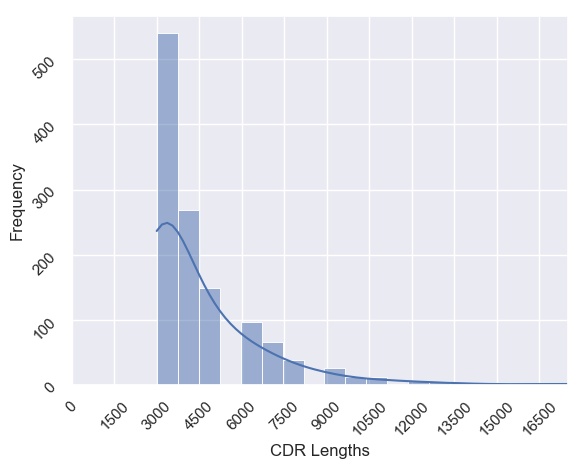

In [318]:
# histogram for length of CDR regions

# plot length graph
plot = sns.histplot(data=filtered['length'], bins=50, kde=True) # plot histogram
plot.ticklabel_format(style='plain', axis='x',useOffset=False)  # get rid of scientific notation values
plot.tick_params(labelrotation=45)  # rotate x ticks
plot.set_xlabel('CDR Lengths')
plot.set_ylabel('Frequency')
plot.set_xticks(np.arange(0, 17500, 1500))
plot.set_xticklabels(plot.get_xticks(), rotation=45)
plot.set_xlim(0,17500)

ChrmNum      object
ranges       object
haplotype    object
start         int64
end           int64
length        int64
dtype: object
     ChrmNum                  ranges haplotype      start        end  length
0          1  (122587375, 122609375)  maternal  122587375  122609375   22000
1          1  (122670375, 122687375)  maternal  122670375  122687375   17000
2          1  (122778375, 122788375)  maternal  122778375  122788375   10000
3          1  (122830375, 122838375)  maternal  122830375  122838375    8000
4          1  (124421626, 124444626)  paternal  124421626  124444626   23000
...      ...                     ...       ...        ...        ...     ...
1255      22    (10031470, 10034470)  paternal   10031470   10034470    3000
1256      22    (10313601, 10317601)  maternal   10313601   10317601    4000
1257      22    (10387601, 10390601)  maternal   10387601   10390601    3000
1258      22    (10421601, 10425601)  maternal   10421601   10425601    4000
1259      22    (10

ValueError: List of boxplot statistics and `positions` values must have same the length

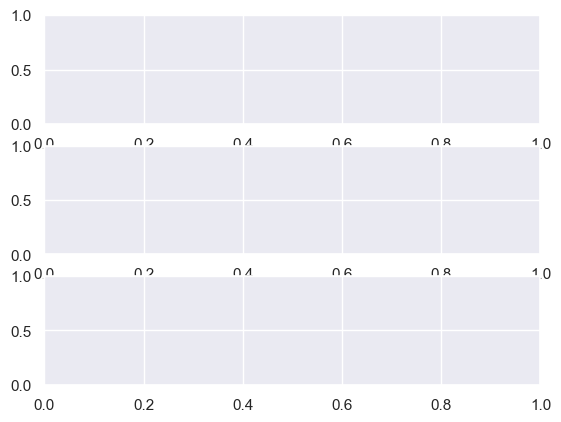

In [319]:
fig, axes = pyplot.subplots(3)

print(filtered.dtypes)
filtered = filtered.reset_index(drop=True)
print(filtered)

sns.boxplot(ax=axes[0],y=filtered["ChrmNum"], x=filtered["length"]).set_title('All Chromosomes (Strict)')

filtered_maternal = filtered.loc[filtered['haplotype'] == 'maternal']
sns.boxplot(ax=axes[1],y=filtered_maternal["ChrmNum"], x=filtered_maternal["length"]).set_title('Maternal Chromosomes (Strict)')

filtered_paternal = filtered.loc[filtered['haplotype'] == 'paternal']
sns.boxplot(ax=axes[2],y=filtered_paternal["ChrmNum"], x=filtered_paternal["length"]).set_title('Paternal Chromosomes (Strict)')

for i in range(3):
        axes[i].set_xlim(0, 50000)
        axes[i].set_xticks(np.arange(0, 50000, 2500))
        axes[i].set_xticklabels(axes[i].get_xticks(), rotation=45)

pyplot.subplots_adjust(wspace=0.3, hspace=0.4)
fig.suptitle('Boxplots of Strict Bed CDR lengths (filtered)', fontsize=20, y=0.93)

In [ ]:
filtered = filtered.reset_index(drop=True)
filtered['length'] = filtered['length'].astype(int)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # print entire dataframe out
#     print(filtered)

# ax = sns.boxplot(x=filtered["length"], y=filtered["ChrmNum"]).set_title('All Chromosomes (Strict)')
uniques.to_csv('uniques.csv')
uniquesO = pd.read_csv('uniques.csv')
print(uniquesO)

      Unnamed: 0 ChrmNum                  ranges haplotype      start  \
0              0       1  (122587375, 122609375)  maternal  122587375   
1              1       1  (122610375, 122652375)  maternal  122610375   
2              2       1  (122670375, 122687375)  maternal  122670375   
3              3       1  (122778375, 122788375)  maternal  122778375   
4              4       1  (122830375, 122838375)  maternal  122830375   
...          ...     ...                     ...       ...        ...   
1430        1430       Y    (18583688, 18589688)  paternal   18583688   
1431        1431       Y    (19126688, 19129688)  paternal   19126688   
1432        1432       Y    (19130688, 19133688)  paternal   19130688   
1433        1433       Y    (19138688, 19141688)  paternal   19138688   
1434        1434       Y    (19142688, 19146688)  paternal   19142688   

            end  length  
0     122609375   22000  
1     122652375   42000  
2     122687375   17000  
3     122788375   1

## Exploring each individual chromosome's CDRs

/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/anaconda3/envs/cse160/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional 

KeyError: 'ChrmNum'

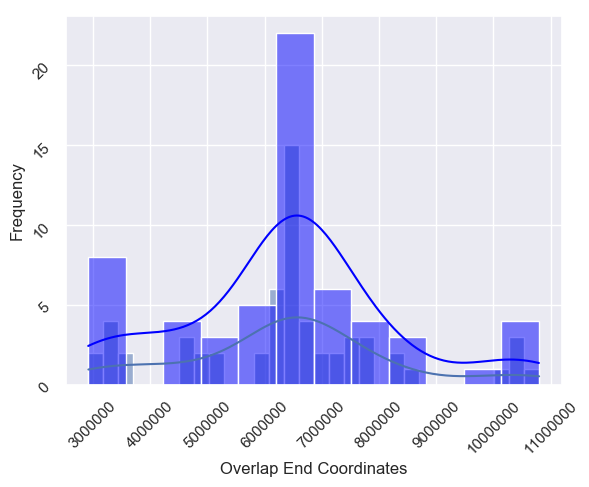

In [ ]:
# maternal chromosomes 1-22
# chrmNum_hap = df.loc[(df['ChrmNum'] == '6') & (df['haplotype'] == 'maternal')]

plot = sns.histplot(data=chrmNum_hap.end, bins=30, kde=True) # plot histogram
plot.ticklabel_format(style='plain', axis='x',useOffset=False)  # get rid of scientific notation values
plot.tick_params(labelrotation=45)  # rotate x ticks
plot.set_xlabel('Overlap End Coordinates')
plot.set_ylabel('Frequency')

plot = sns.histplot(chrmNum_hap.start, kde=True, color='blue')
plot.ticklabel_format(style='plain', axis='x',useOffset=False)  # get rid of scientific notation values
plot.tick_params(labelrotation=45)  # rotate x ticks

# maternal chromosomes 1-22
for chr in range(1,23):
    chrmNum_hap = df.loc[(df['ChrmNum'] == chr) & (df['haplotype'] == 'maternal')]
    pyplot.figure()
    plot = sns.histplot(chrmNum_hap.start, kde=True, color='blue')
    plot.ticklabel_format(style='plain', axis='x',useOffset=False)  # get rid of scientific notation values
    plot.tick_params(labelrotation=45)  # rotate x ticks
    plot.set_title('Chr'+str(chr) + ' Maternal')

In [ ]:
# paternal chromosomes 1-22
# for chr in range(1,23):
#     chrmNum_hap = df.loc[(df['ChrmNum'] == chr) & (df['haplotype'] == 'paternal')]
#     pyplot.figure()
#     plot = sns.histplot(chrmNum_hap.start, kde=True, color='blue')
#     plot.ticklabel_format(style='plain', axis='x',useOffset=False)  # get rid of scientific notation values
#     plot.tick_params(labelrotation=45)  # rotate x ticks
#     plot.set_title('Chr'+str(chr) + ' Paternal')

In [ ]:
# Density plot
df = pd.DataFrame([(cdr.numChr, cdr.start, cdr.end, cdr.hap) for cdr in cdr_list], 
                    columns=['ChrmNum','start', 'end', 'haplotype'])

from natsort import index_natsorted, order_by_index

df = df.reindex(index=order_by_index(df.index, index_natsorted(df['ChrmNum'], reverse=False)))
# df.sort_values('ChrmNum')
# print(df.to_string())

rangesDF = pd.DataFrame([(cdr.numChr, (int(cdr.start), int(cdr.end)), cdr.hap) for cdr in cdr_list],
                          columns=['ChrmNum','Coordinates', 'haplotype'])

# test different colors
# start coordinates
# pyplot.figure()
# sns.kdeplot(
#    data=df, x="start", hue="ChrmNum",
#    fill=True, common_norm=False, palette="crest",
#    alpha=0.5, linewidth=1,
# )

# # end coordinates
# pyplot.figure()
# sns.kdeplot(
#    data=df, x="end", hue="ChrmNum",
#    fill=True, common_norm=False, palette="crest",
#    alpha=0.5, linewidth=1,
# )


## Boxplot of CDR locations


      ChrmNum                  ranges haplotype      start        end  length
42480       1  (122587375, 122609375)  maternal  122587375  122609375   22000
42481       1  (122587375, 122609375)  maternal  122587375  122609375   22000
42482       1  (122587375, 122609375)  maternal  122587375  122609375   22000
42483       1  (122587375, 122609375)  maternal  122587375  122609375   22000
42484       1  (122587375, 122609375)  maternal  122587375  122609375   22000
...       ...                     ...       ...        ...        ...     ...
13411       X    (61295698, 61301698)  maternal   61295698   61301698    6000
13412       X    (61295698, 61301698)  maternal   61295698   61301698    6000
13413       X    (61295698, 61301698)  maternal   61295698   61301698    6000
13414       X    (61295698, 61301698)  maternal   61295698   61301698    6000
13415       X    (61295698, 61301698)  maternal   61295698   61301698    6000

[23816 rows x 6 columns]


Text(0.5, 0.93, 'Boxplots of Strict Bed CDR Locations')

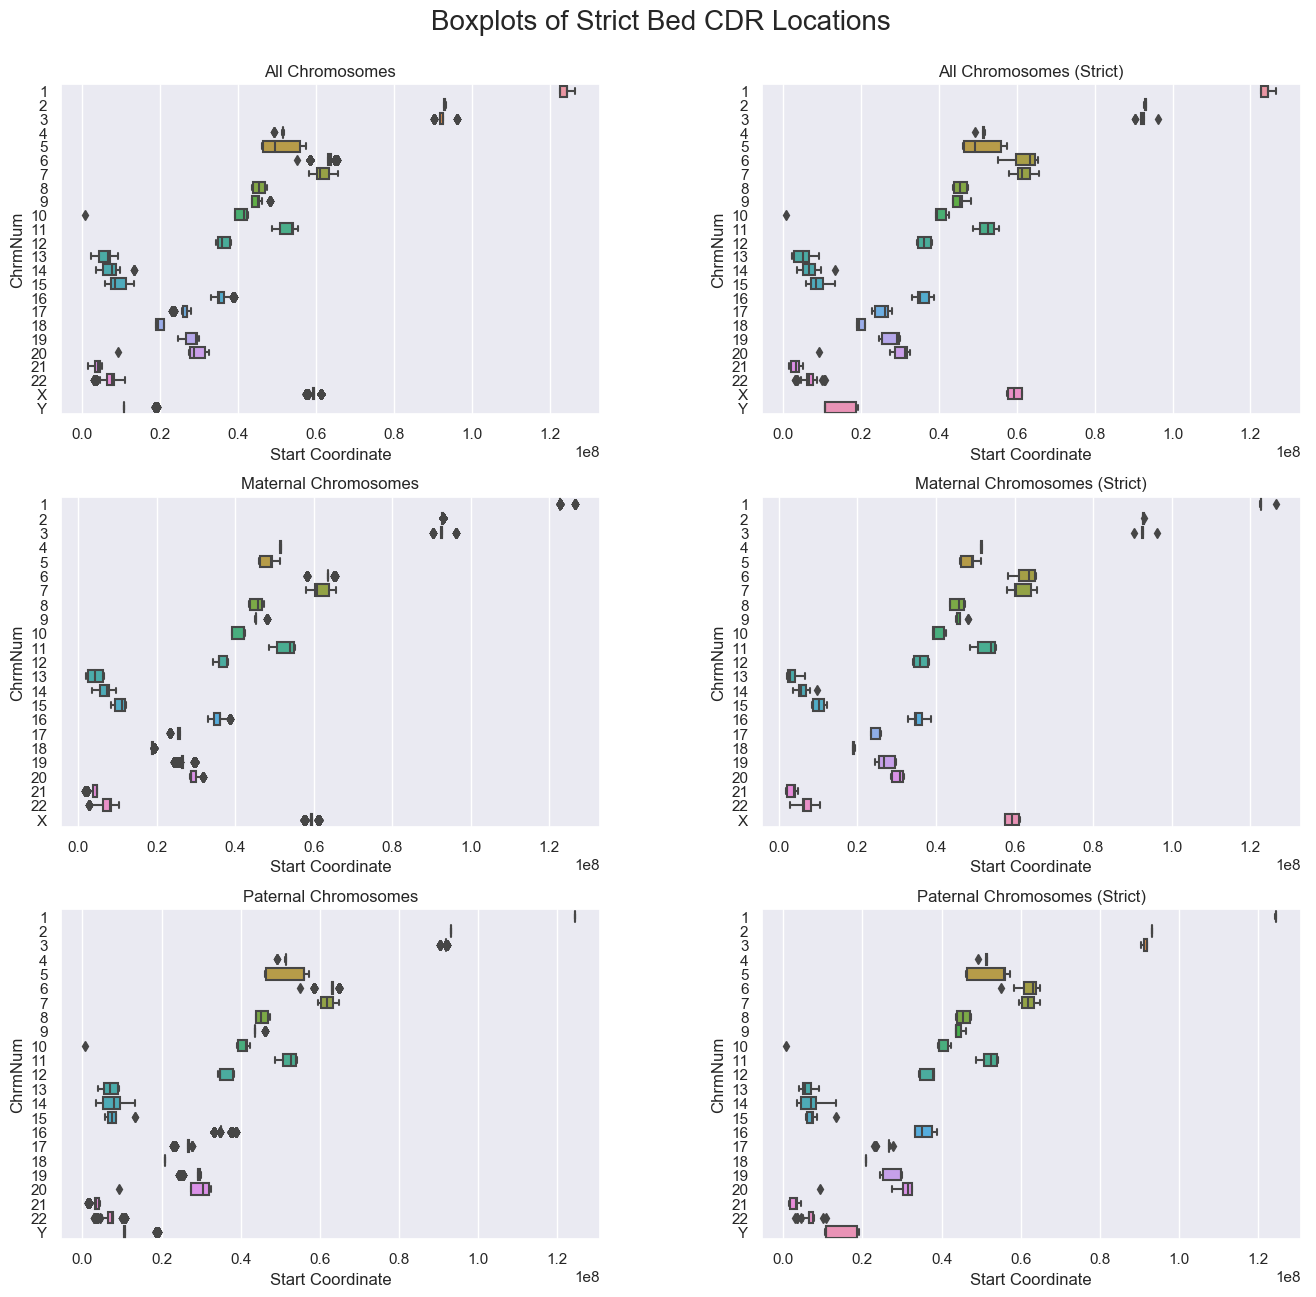

In [ ]:
# boxplot of CDR locations
# chrmNum_hap = df.loc[(df['ChrmNum'] == chr) & (df['haplotype'] == 'paternal')]

fig, axes = pyplot.subplots(3,2, figsize=(16,15))

sns.boxplot(ax=axes[0,0],y=allDF["ChrmNum"], x=allDF["start"]).set_title('All Chromosomes')
axes[0,0].set(xlabel='Start Coordinate')
# axes[0,0].ticklabel_format(style='plain', axis='x',useOffset=False)
# axes[0,0].tick_params(labelrotation=45)

df_maternal = allDF.loc[allDF['haplotype'] == 'maternal']
print(df_maternal)
sns.boxplot(ax=axes[1,0], y=df_maternal["ChrmNum"], x=df_maternal["start"]).set_title('Maternal Chromosomes')
axes[1,0].set(xlabel='Start Coordinate')

df_paternal = allDF.loc[allDF['haplotype'] == 'paternal']
sns.boxplot(ax=axes[2,0],y=df_paternal["ChrmNum"], x=df_paternal["start"]).set_title('Paternal Chromosomes')
axes[2,0].set(xlabel='Start Coordinate')

sns.boxplot(ax=axes[0,1],y=uniques["ChrmNum"], x=uniques["start"]).set_title('All Chromosomes (Strict)')
axes[0,1].set(xlabel='Start Coordinate')

df_maternal = uniques.loc[uniques['haplotype'] == 'maternal']
sns.boxplot(ax=axes[1,1],y=df_maternal["ChrmNum"], x=df_maternal["start"]).set_title('Maternal Chromosomes (Strict)')
axes[1,1].set(xlabel='Start Coordinate')

df_paternal = uniques.loc[uniques['haplotype'] == 'paternal']
sns.boxplot(ax=axes[2,1],y=df_paternal["ChrmNum"], x=df_paternal["start"]).set_title('Paternal Chromosomes (Strict)')
axes[2,1].set(xlabel='Start Coordinate')

pyplot.subplots_adjust(wspace=0.3, hspace=0.25)
fig.suptitle('Boxplots of Strict Bed CDR Locations', fontsize=20, y=0.93)

## Boxplots of HMM predicted CDRs

    ChrmNum                  ranges haplotype      start        end  length
152       1  (122588553, 122607144)  MATERNAL  122588553  122607144   18591
153       1  (122608264, 122609774)  MATERNAL  122608264  122609774    1510
154       1  (122610340, 122652509)  MATERNAL  122610340  122652509   42169
155       1  (122670602, 122671622)  MATERNAL  122670602  122671622    1020
156       1  (122674913, 122686663)  MATERNAL  122674913  122686663   11750
..      ...                     ...       ...        ...        ...     ...
507       X    (59515374, 59517065)  MATERNAL   59515374   59517065    1691
508       X    (61168247, 61173446)  MATERNAL   61168247   61173446    5199
509       X    (61265884, 61268774)  MATERNAL   61265884   61268774    2890
510       X    (61275238, 61279900)  MATERNAL   61275238   61279900    4662
511       X    (61296286, 61303543)  MATERNAL   61296286   61303543    7257

[296 rows x 6 columns]


Text(0.5, 0.93, 'Boxplots of HMM Bed CDR Locations')

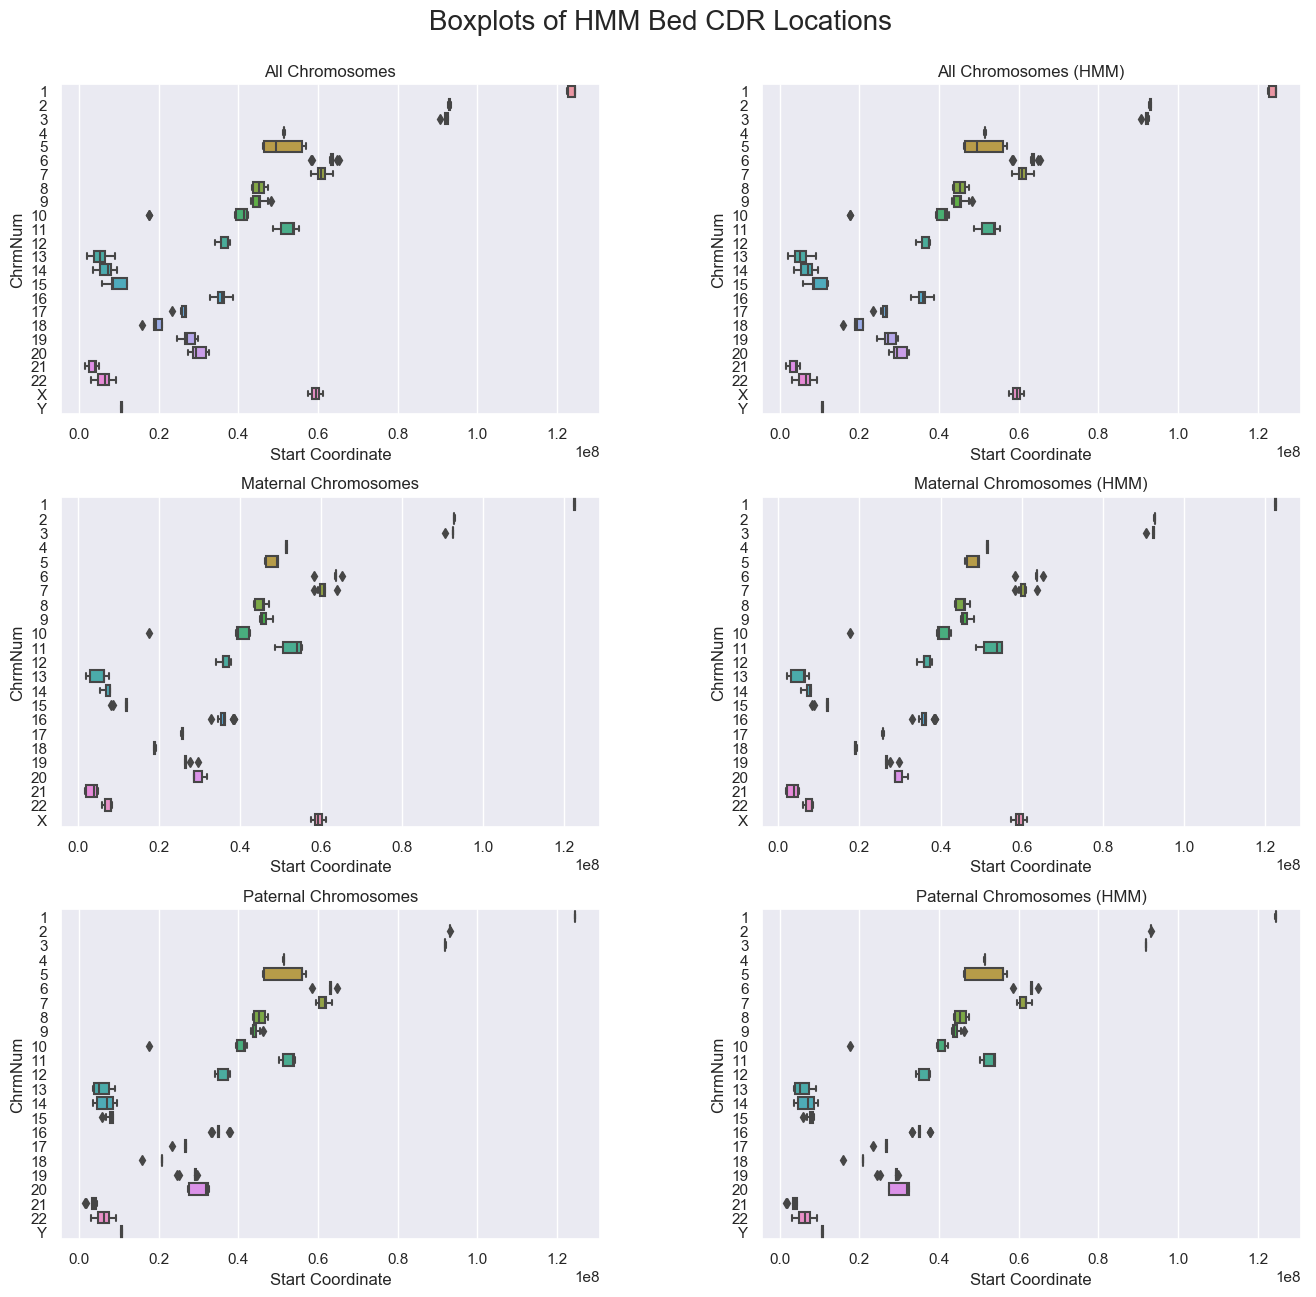

In [ ]:
# HMM location boxplots

fig, axes = pyplot.subplots(3,2, figsize=(16,15))

sns.boxplot(ax=axes[0,0],y=allHMM["ChrmNum"], x=allHMM["start"]).set_title('All Chromosomes')
# axes[0,0].ticklabel_format(style='plain', axis='x',useOffset=False)
# axes[0,0].tick_params(labelrotation=45)

df_maternal = allHMM.loc[allHMM['haplotype'] == 'MATERNAL']
print(df_maternal)
sns.boxplot(ax=axes[1,0], y=df_maternal["ChrmNum"], x=df_maternal["start"]).set_title('Maternal Chromosomes')

df_paternal = allHMM.loc[allHMM['haplotype'] == 'PATERNAL']
sns.boxplot(ax=axes[2,0],y=df_paternal["ChrmNum"], x=df_paternal["start"]).set_title('Paternal Chromosomes')

sns.boxplot(ax=axes[0,1],y=uniqueHMM["ChrmNum"], x=uniqueHMM["start"]).set_title('All Chromosomes (HMM)')

df_maternal = uniqueHMM.loc[uniqueHMM['haplotype'] == 'MATERNAL']
sns.boxplot(ax=axes[1,1],y=df_maternal["ChrmNum"], x=df_maternal["start"]).set_title('Maternal Chromosomes (HMM)')

df_paternal = uniqueHMM.loc[uniqueHMM['haplotype'] == 'PATERNAL']
sns.boxplot(ax=axes[2,1],y=df_paternal["ChrmNum"], x=df_paternal["start"]).set_title('Paternal Chromosomes (HMM)')

for i in range(3):
    for j in range(2):
        axes[i,j].set(xlabel='Start Coordinate')

pyplot.subplots_adjust(wspace=0.3, hspace=0.25)
fig.suptitle('Boxplots of HMM Bed CDR Locations', fontsize=20, y=0.93)

## Boxplot of CDR sizes


Text(0.5, 0.93, 'Boxplots of Strict Bed CDR lengths')

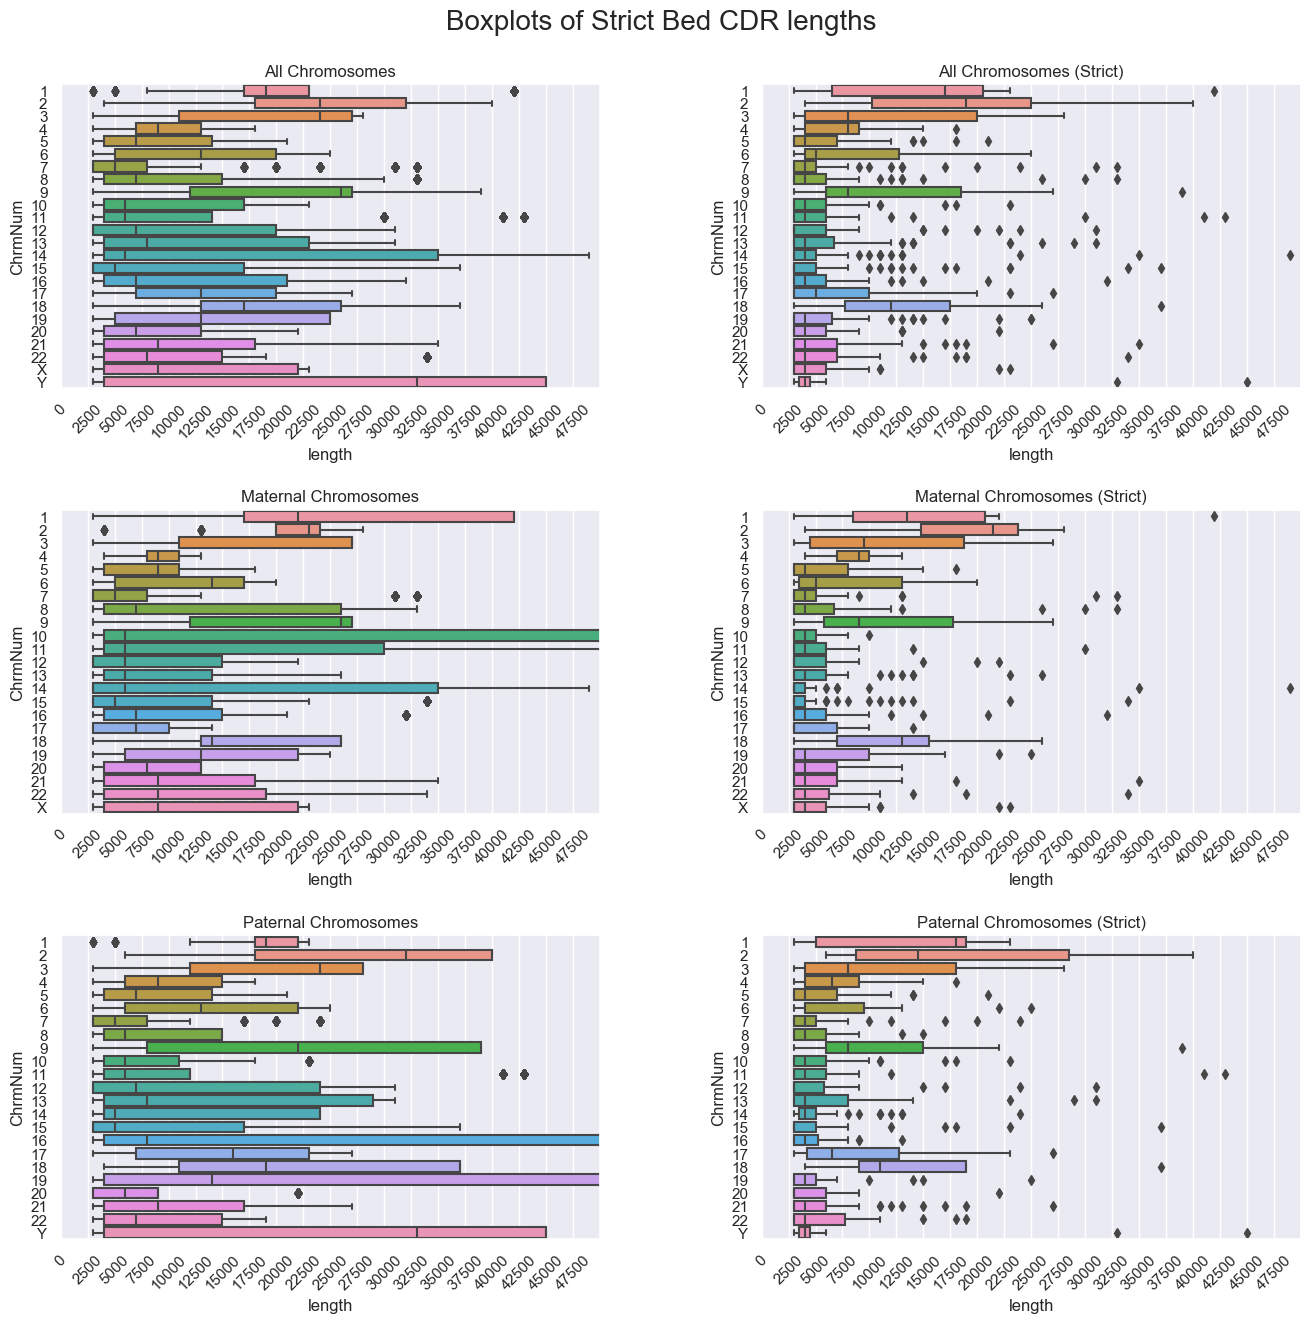

In [ ]:
# boxplot of CDR lengths
fig, axes = pyplot.subplots(3,2, figsize=(16,15))

sns.boxplot(ax=axes[0,0],y=allDF["ChrmNum"], x=allDF["length"]).set_title('All Chromosomes')

df_maternal = allDF.loc[allDF['haplotype'] == 'maternal']
sns.boxplot(ax=axes[1,0], y=df_maternal["ChrmNum"], x=df_maternal["length"]).set_title('Maternal Chromosomes')

df_paternal = allDF.loc[allDF['haplotype'] == 'paternal']
sns.boxplot(ax=axes[2,0],y=df_paternal["ChrmNum"], x=df_paternal["length"]).set_title('Paternal Chromosomes')

sns.boxplot(ax=axes[0,1],y=uniques["ChrmNum"], x=uniques["length"]).set_title('All Chromosomes (Strict)')

df_maternal = uniques.loc[uniques['haplotype'] == 'maternal']
sns.boxplot(ax=axes[1,1],y=df_maternal["ChrmNum"], x=df_maternal["length"]).set_title('Maternal Chromosomes (Strict)')

df_paternal = uniques.loc[uniques['haplotype'] == 'paternal']
sns.boxplot(ax=axes[2,1],y=df_paternal["ChrmNum"], x=df_paternal["length"]).set_title('Paternal Chromosomes (Strict)')

for i in range(3):
    for j in range(2):
        axes[i,j].set_xlim(0, 50000)
        axes[i,j].set_xticks(np.arange(0, 50000, 2500))
        axes[i,j].set_xticklabels(axes[i,j].get_xticks(), rotation=45)

pyplot.subplots_adjust(wspace=0.3, hspace=0.4)
fig.suptitle('Boxplots of Strict Bed CDR lengths', fontsize=20, y=0.93)

## Boxplot of HMM predicted CDR sizes


Text(0.5, 0.93, 'Boxplots of HMM Bed CDR lengths')

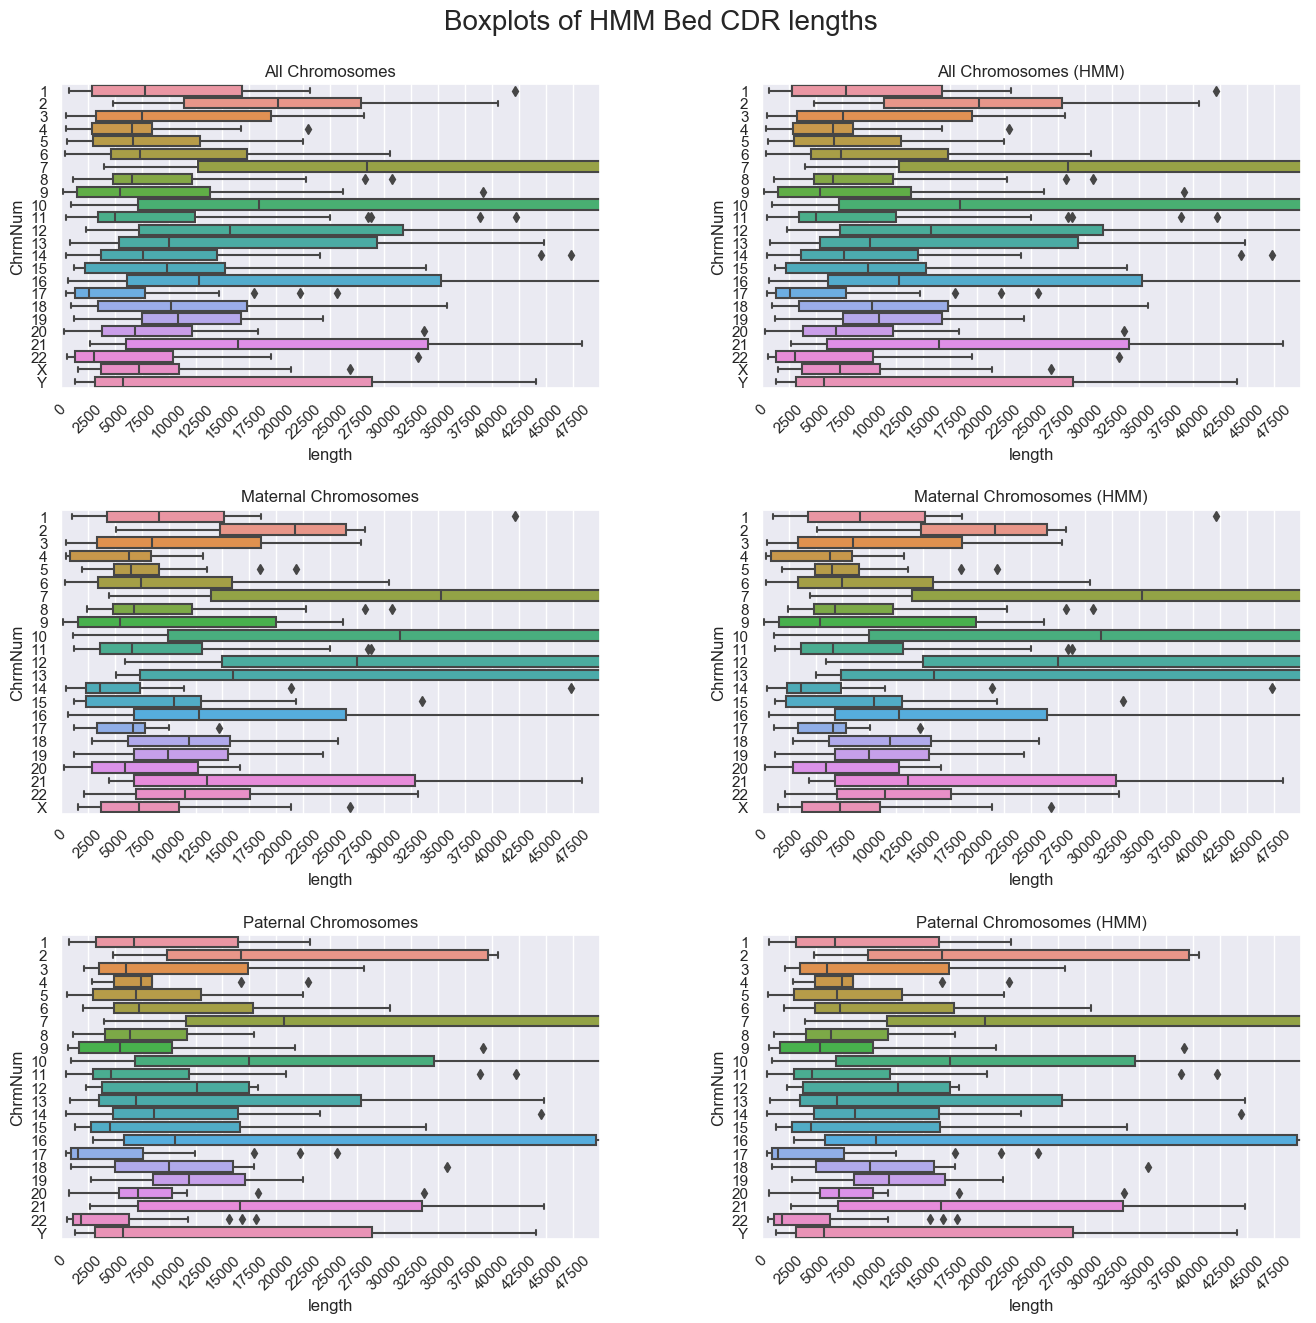

In [ ]:
# boxplot of HMM CDR lengths
fig, axes = pyplot.subplots(3,2, figsize=(16,15))

sns.boxplot(ax=axes[0,0],y=allHMM["ChrmNum"], x=allHMM["length"]).set_title('All Chromosomes')

df_maternal = allHMM.loc[allHMM['haplotype'] == 'MATERNAL']
sns.boxplot(ax=axes[1,0], y=df_maternal["ChrmNum"], x=df_maternal["length"]).set_title('Maternal Chromosomes')

df_paternal = allHMM.loc[allHMM['haplotype'] == 'PATERNAL']
sns.boxplot(ax=axes[2,0],y=df_paternal["ChrmNum"], x=df_paternal["length"]).set_title('Paternal Chromosomes')

sns.boxplot(ax=axes[0,1],y=uniqueHMM["ChrmNum"], x=uniqueHMM["length"]).set_title('All Chromosomes (HMM)')

df_maternal = uniqueHMM.loc[uniqueHMM['haplotype'] == 'MATERNAL']
sns.boxplot(ax=axes[1,1],y=df_maternal["ChrmNum"], x=df_maternal["length"]).set_title('Maternal Chromosomes (HMM)')

df_paternal = uniqueHMM.loc[uniqueHMM['haplotype'] == 'PATERNAL']
sns.boxplot(ax=axes[2,1],y=df_paternal["ChrmNum"], x=df_paternal["length"]).set_title('Paternal Chromosomes (HMM)')

for i in range(3):
    for j in range(2):
        axes[i,j].set_xlim(0, 50000)
        axes[i,j].set_xticks(np.arange(0, 50000, 2500))
        axes[i,j].set_xticklabels(axes[i,j].get_xticks(), rotation=45)

pyplot.subplots_adjust(wspace=0.3, hspace=0.4)
fig.suptitle('Boxplots of HMM Bed CDR lengths', fontsize=20, y=0.93)

# Dotplot of HMM CDR lengths
HMM BED files have no duplicates!!!


Text(0.5, 0.93, 'Dotplots of HMM Bed CDR lengths')

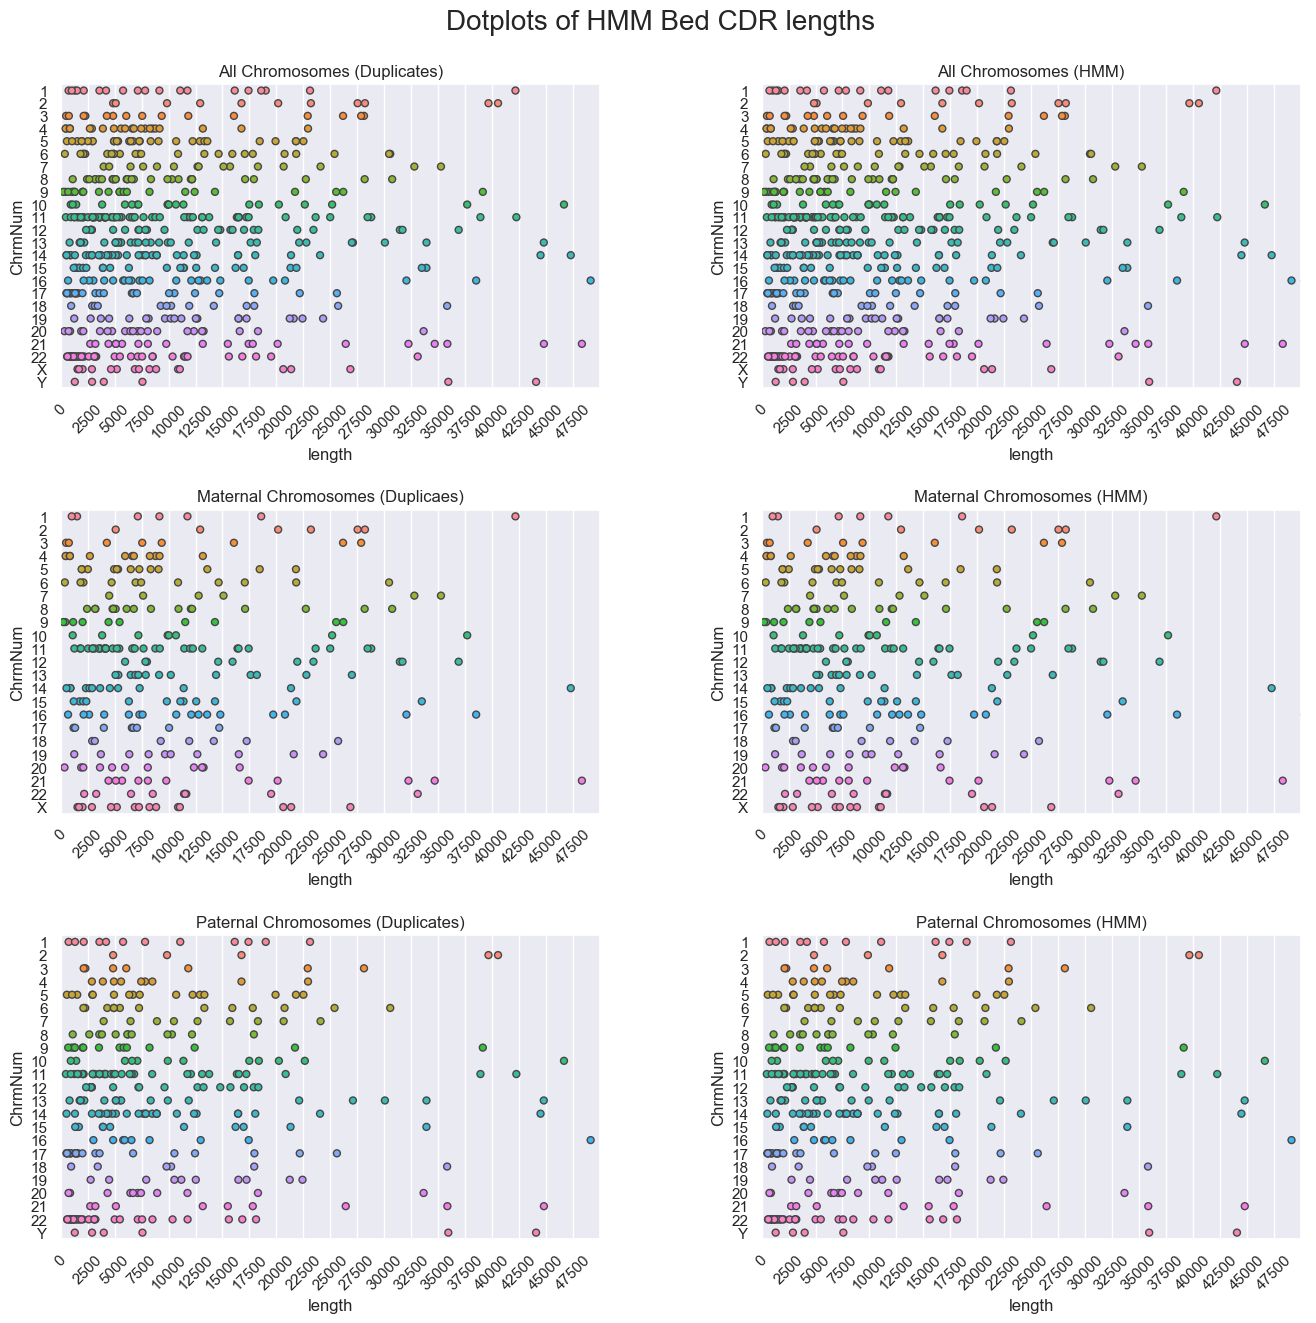

In [ ]:
# dotplot of HMM CDR lengths
fig, axes = pyplot.subplots(3,2, figsize=(16,15))

sns.stripplot(ax=axes[0,0],y=allHMM["ChrmNum"], x=allHMM["length"], jitter=False, linewidth=1).set_title('All Chromosomes (Duplicates)')

df_maternal = allHMM.loc[allHMM['haplotype'] == 'MATERNAL']
sns.stripplot(ax=axes[1,0], y=df_maternal["ChrmNum"], x=df_maternal["length"], jitter=False, linewidth=1).set_title('Maternal Chromosomes (Duplicaes)')

df_paternal = allHMM.loc[allHMM['haplotype'] == 'PATERNAL']
sns.stripplot(ax=axes[2,0],y=df_paternal["ChrmNum"], x=df_paternal["length"], jitter=False, linewidth=1).set_title('Paternal Chromosomes (Duplicates)')

sns.stripplot(ax=axes[0,1],y=uniqueHMM["ChrmNum"], x=uniqueHMM["length"], jitter=False, linewidth=1).set_title('All Chromosomes (HMM)')

df_maternal = uniqueHMM.loc[uniqueHMM['haplotype'] == 'MATERNAL']
sns.stripplot(ax=axes[1,1],y=df_maternal["ChrmNum"], x=df_maternal["length"], jitter=False, linewidth=1).set_title('Maternal Chromosomes (HMM)')

df_paternal = uniqueHMM.loc[uniqueHMM['haplotype'] == 'PATERNAL']
sns.stripplot(ax=axes[2,1],y=df_paternal["ChrmNum"], x=df_paternal["length"], jitter=False, linewidth=1).set_title('Paternal Chromosomes (HMM)')

for i in range(3):
    for j in range(2):
        axes[i,j].set_xlim(0, 50000)
        axes[i,j].set_xticks(np.arange(0, 50000, 2500))
        axes[i,j].set_xticklabels(axes[i,j].get_xticks(), rotation=45)

pyplot.subplots_adjust(wspace=0.3, hspace=0.4)
fig.suptitle('Dotplots of HMM Bed CDR lengths', fontsize=20, y=0.93)

# Dotplot of strict BED CDR lengths


Text(0.5, 0.93, 'Dotplots of Strict Bed CDR lengths')

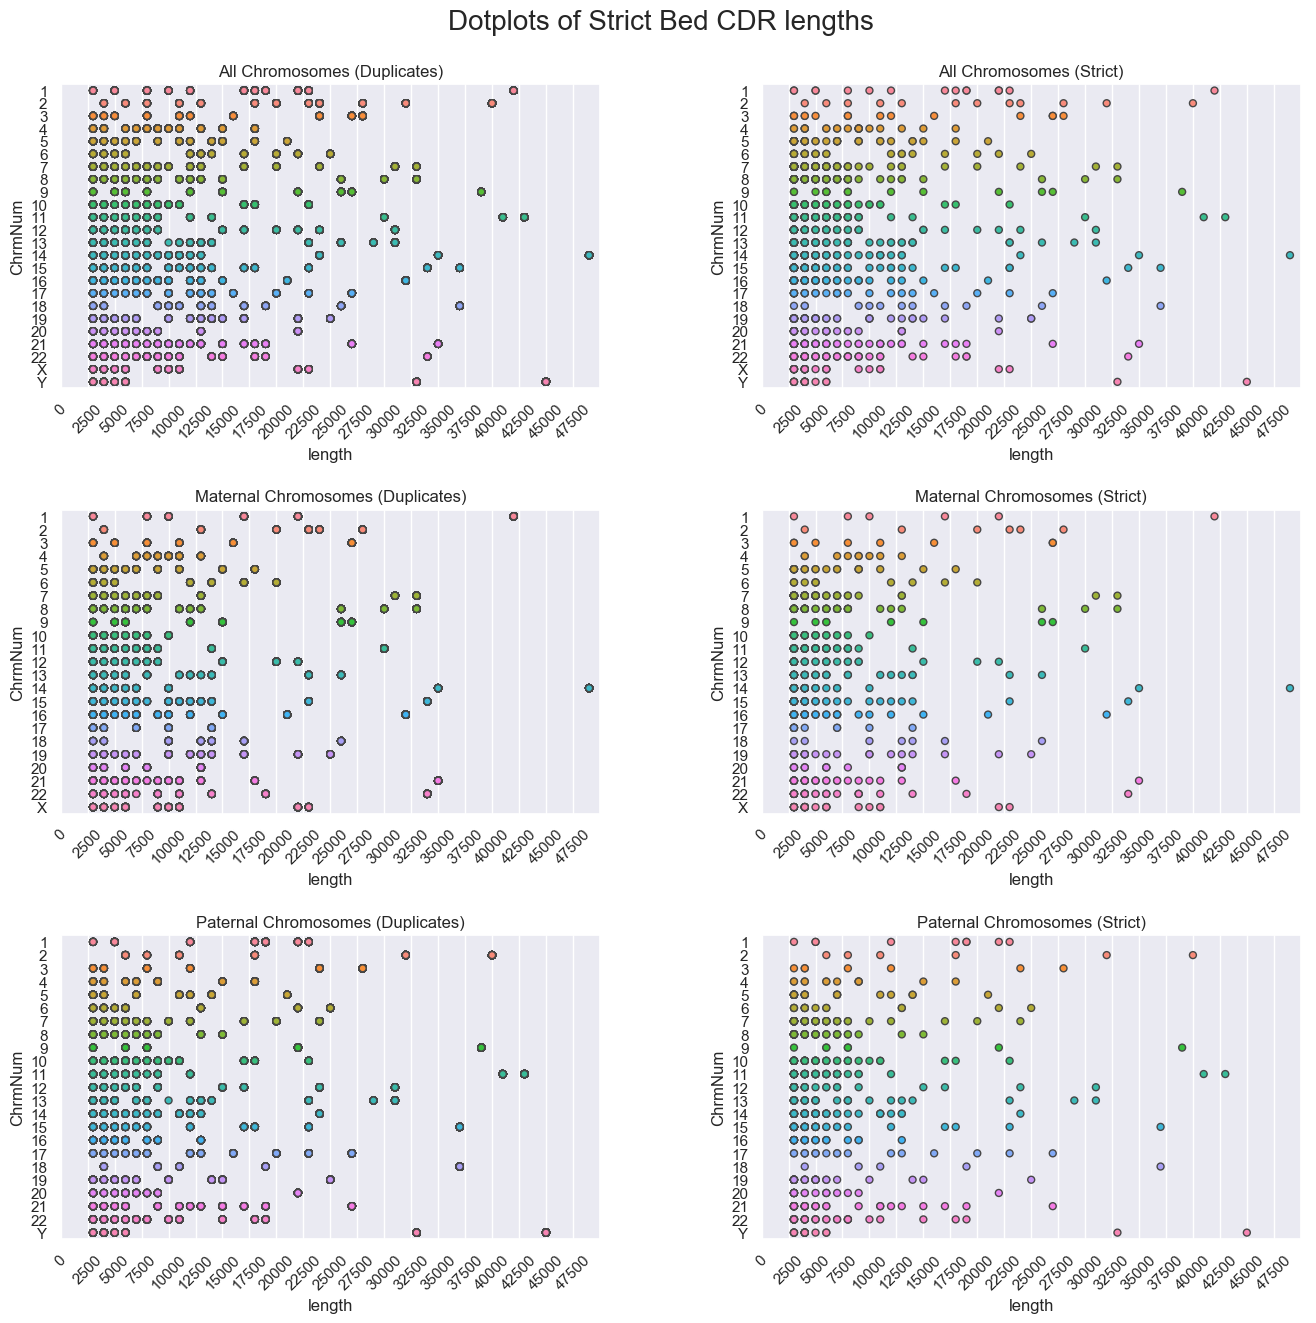

In [ ]:
# dotplot of strict bed CDR lengths

fig, axes = pyplot.subplots(3,2, figsize=(16,15))

sns.stripplot(ax=axes[0,0],y=allDF["ChrmNum"], x=allDF["length"], jitter=False, linewidth=1).set_title('All Chromosomes (Duplicates)')

df_maternal = allDF.loc[allDF['haplotype'] == 'maternal']
sns.stripplot(ax=axes[1,0], y=df_maternal["ChrmNum"], x=df_maternal["length"], jitter=False, linewidth=1).set_title('Maternal Chromosomes (Duplicates)')

df_paternal = allDF.loc[allDF['haplotype'] == 'paternal']
sns.stripplot(ax=axes[2,0],y=df_paternal["ChrmNum"], x=df_paternal["length"], jitter=False, linewidth=1).set_title('Paternal Chromosomes (Duplicates)')

sns.stripplot(ax=axes[0,1],y=uniques["ChrmNum"], x=uniques["length"], jitter=False, linewidth=1).set_title('All Chromosomes (Strict)')

df_maternal = uniques.loc[uniques['haplotype'] == 'maternal']
sns.stripplot(ax=axes[1,1],y=df_maternal["ChrmNum"], x=df_maternal["length"], jitter=False, linewidth=1).set_title('Maternal Chromosomes (Strict)')

df_paternal = uniques.loc[uniques['haplotype'] == 'paternal']
sns.stripplot(ax=axes[2,1],y=df_paternal["ChrmNum"], x=df_paternal["length"], jitter=False, linewidth=1).set_title('Paternal Chromosomes (Strict)')

for i in range(3):
    for j in range(2):
        axes[i,j].set_xlim(0, 50000)
        axes[i,j].set_xticks(np.arange(0, 50000, 2500))
        axes[i,j].set_xticklabels(axes[i,j].get_xticks(), rotation=45)

pyplot.subplots_adjust(wspace=0.3, hspace=0.4)
fig.suptitle('Dotplots of Strict Bed CDR lengths', fontsize=20, y=0.93)

In [ ]:
# summary stats on CDR lengths
# mean
# range
# median
# max, min
# filter out some outliers

# Using bedtools closest to find closest distances between regions 

In [ ]:
# now create bedfiles for just the unique CDRs so we can do bedtools closest

def createFile(df):
    """
    Function for creating new BED files that store just the 
    unique CDRs for each chromosome
    """
    num = df['chr'].iloc[0]
    hap = df['haplotype'].iloc[0]
    df = df[['chr', 'start', 'end']]
    df.to_csv('/Users/emilyxu/Desktop/cdrproject/filteredIntersectUniques/' + str(num) + hap + '.bed',sep='\t', header=False, index=False)


# chr 1-22 paternal and maternal
# haps = ['maternal', 'paternal']
# for i in range(1,23):
#     for j in range(len(haps)):
#         newDF = uniques[(uniques['ChrmNum'] == i) & (uniques['haplotype'] == haps[j])]
#         newDF = newDF[['ChrmNum', 'haplotype', 'start', 'end']]
#         createFile(newDF)

In [ ]:
# chr X and Y
xDF = uniques[(uniques['ChrmNum'] == 'X')]
yDF = uniques[(uniques['ChrmNum'] == 'Y')]
xDF = xDF[['ChrmNum', 'haplotype', 'start', 'end']]
yDF = yDF[['ChrmNum', 'haplotype', 'start', 'end']]
createFile(xDF)
createFile(yDF)

In [ ]:
# bedtoolsCommand = 'bedtools closest -k 4 -a '
# filePath = '/Users/emilyxu/Desktop/cdrproject/intersectUniques/'
# for i in range(2, 23):
#     print('Chr' + str(i) + 'Maternal')
#     print(bedtoolsCommand + filePath + str(i) + 'maternal.bed -b ' 
#           + filePath + str(i) + 'maternal.bed -d > strictCh' + str(i) + '_maternal_closest_k.bed')
#     print()
    

In [ ]:
# for i in range(1, 23):
#     print('Chr' + str(i) + 'Paternal')
#     print(bedtoolsCommand + filePath + str(i) + 'paternal.bed -b ' 
#           + filePath + str(i) + 'paternal.bed -d > strictCh' + str(i) + '_paternal_closest_k.bed')
#     print()

# Storing Bedtools closest outputs as pandas dataframe

In [ ]:
import glob
path = '/Users/emilyxu/Desktop/cdrproject/closestDistOutputs'
filenames = glob.glob(path + "/*.bed")
print('File names: ', filenames)
print('num of files: ', len(filenames))

# store all file info into one dataframe
finalBEDfiles = pd.DataFrame()
for file in filenames:
    df = pd.read_csv(file, sep='\t', header=None)
    header = ['chr1', 'start1', 'end1', 'chr2', 'start2', 'end2', 'distance', 'haplotype']
    df['haplotype'] = str(file.split('/')[-1]).split('_')[1]
    df.columns = header[:len(df.columns)]
    finalBEDfiles = pd.concat([finalBEDfiles, df])

finalBEDfiles['chr1'] = finalBEDfiles['chr1'].astype(str)

finalBEDfiles = finalBEDfiles.sort_values('chr1')

# finalBEDfiles = finalBEDfiles.sort(['chr1'])

finalBEDfiles = finalBEDfiles.loc[finalBEDfiles['distance'] != 0]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # print entire dataframe out
    print(finalBEDfiles)

print('num of regions: ', len(finalBEDfiles))


File names:  ['/Users/emilyxu/Desktop/cdrproject/closestDistOutputs/strictCh14_maternal_closest_k.bed', '/Users/emilyxu/Desktop/cdrproject/closestDistOutputs/strictCh9_maternal_closest_k.bed', '/Users/emilyxu/Desktop/cdrproject/closestDistOutputs/strictCh3_maternal_closest_k.bed', '/Users/emilyxu/Desktop/cdrproject/closestDistOutputs/strictChY_paternal_closest_k.bed', '/Users/emilyxu/Desktop/cdrproject/closestDistOutputs/strictCh22_maternal_closest_k.bed', '/Users/emilyxu/Desktop/cdrproject/closestDistOutputs/strictCh13_maternal_closest_k.bed', '/Users/emilyxu/Desktop/cdrproject/closestDistOutputs/strictCh4_maternal_closest_k.bed', '/Users/emilyxu/Desktop/cdrproject/closestDistOutputs/strictCh19_maternal_closest_k.bed', '/Users/emilyxu/Desktop/cdrproject/closestDistOutputs/strictCh21_maternal_closest_k.bed', '/Users/emilyxu/Desktop/cdrproject/closestDistOutputs/strictCh7_maternal_closest_k.bed', '/Users/emilyxu/Desktop/cdrproject/closestDistOutputs/strictCh10_maternal_closest_k.bed', '

In [ ]:

Xchr = uniques[uniques['ChrmNum']=='X']
Xchr.describe()
Xchr = finalBEDfiles[finalBEDfiles['chr']=='chrX_MATERNAL']
Xchr.describe()
finalBEDfiles


,chr,start,end,haplotype,range
0,chr8_MATERNAL,45119021,45122021,MATERNAL,"(45119021, 45122021)"
1,chr8_MATERNAL,45119021,45122021,MATERNAL,"(45119021, 45122021)"
2,chr8_MATERNAL,45119021,45122021,MATERNAL,"(45119021, 45122021)"
3,chr8_MATERNAL,45119021,45122021,MATERNAL,"(45119021, 45122021)"
4,chr8_MATERNAL,45119021,45122021,MATERNAL,"(45119021, 45122021)"
...,...,...,...,...,...
284,chr17,26034665,26037665,MATERNAL,"(26034665, 26037665)"
285,chr17,26034665,26037665,MATERNAL,"(26034665, 26037665)"
286,chr17,26034665,26037665,MATERNAL,"(26034665, 26037665)"
287,chr17,26034665,26037665,MATERNAL,"(26034665, 26037665)"


# Clustering Outputs for Chromosome X

In [ ]:
path1='/Users/emilyxu/Desktop/cdrproject/clusterOutputs/chX_maternal_cluster_strand_26000_2.bed'
path2='/Users/emilyxu/Desktop/cdrproject/clusterOutputs/chX_maternal_cluster_strand_17000_2.bed'
path3='/Users/emilyxu/Desktop/cdrproject/clusterOutputs/chX_maternal_cluster_strand_10000_2.bed'

in_fh1=open(path1,'r')
in_fh2=open(path2,'r')
in_fh3=open(path3,'r')

df = pd.read_csv(in_fh1, sep='\t', header=None)
header = ['chromosome', 'start', 'end', 'cluster']
df.columns = header[:len(df.columns)]
clustered26000 = df[['start', 'end']].groupby(df['cluster'])

df = pd.read_csv(in_fh2, sep='\t', header=None)
header = ['chromosome', 'start', 'end', 'cluster']
df.columns = header[:len(df.columns)]
clustered17000 = df[['start', 'end']].groupby(df['cluster'])

df = pd.read_csv(in_fh3, sep='\t', header=None)
header = ['chromosome', 'start', 'end', 'cluster']
df.columns = header[:len(df.columns)]
clustered10000 = df[['start', 'end']].groupby(df['cluster'])

result26000 = clustered26000.agg({'start': ['count', 'min'],'end': ['count', 'max']})
result17000 = clustered17000.agg({'start': ['count', 'min'],'end': ['count', 'max']})
result10000 = clustered10000.agg({'start': ['count', 'min'],'end': ['count', 'max']})

print()
print('\033[1mChromosome X CDR clustering\033[0m' + '\n')
print('cluster distance: 26000bp (mean)')
print(result26000)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print()
print()
print('cluster distance: 17000bp (median)')
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(clustered17000.count())
print(result17000)
print()
print('cluster distance: 10000bp (25% percentile)')
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(clustered10000.count())
print(result10000)
print()
print(result26000.columns)

bedfile_name = 'chrX_cluster_26000bp.bed'
with open(bedfile_name, 'w') as f:
    for index,cluster in result26000.iterrows():
        f.write(f"chrX_MATERNAL\t{cluster[('start','min')]}\t{cluster['end','max']}\n")

# way to filter out small CDRs


Chromosome X CDR clustering

cluster distance: 26000bp (mean)
        start             end          
        count       min count       max
cluster                                
1           5  57494698     5  57536698
2           4  57650698     4  57704698
3           4  57748698     4  57792698
4           1  57831698     1  57834698
5           2  59261698     2  59296698
6           1  59362698     1  59373698
7           3  59427698     3  59509698
8          10  61167698    10  61301698

cluster distance: 17000bp (median)
        start             end          
        count       min count       max
cluster                                
1           5  57494698     5  57536698
2           3  57650698     3  57679698
3           1  57701698     1  57704698
4           4  57748698     4  57792698
5           1  57831698     1  57834698
6           2  59261698     2  59296698
7           1  59362698     1  59373698
8           1  59427698     1  59450698
9           2  594706

# Current plan:
1. generate clustered CDR bedfiles for all chromosomes (hg002)
2. create min size filters for chromosomes (this could depend from chromosome to chromosome)
3. visualize individual and clustered CDRs in IGV
4. show how the size of clustered CDR region differs from generation to generation for each chromosome

In [ ]:
lst = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,'X','Y']
haps = ['MATERNAL','PATERNAL']
chrNames = []
for i in range(len(lst)):
    for j in range(len(haps)):
        chrNames.append(f'chr{lst[i]}_{haps[j]}')
chrNames.remove('chrX_PATERNAL')
chrNames.remove('chrY_MATERNAL')
print(len(chrNames))

['chr1_MATERNAL', 'chr1_PATERNAL', 'chr2_MATERNAL', 'chr2_PATERNAL', 'chr3_MATERNAL', 'chr3_PATERNAL', 'chr4_MATERNAL', 'chr4_PATERNAL', 'chr5_MATERNAL', 'chr5_PATERNAL', 'chr6_MATERNAL', 'chr6_PATERNAL', 'chr7_MATERNAL', 'chr7_PATERNAL', 'chr8_MATERNAL', 'chr8_PATERNAL', 'chr9_MATERNAL', 'chr9_PATERNAL', 'chr10_MATERNAL', 'chr10_PATERNAL', 'chr11_MATERNAL', 'chr11_PATERNAL', 'chr12_MATERNAL', 'chr12_PATERNAL', 'chr13_MATERNAL', 'chr13_PATERNAL', 'chr14_MATERNAL', 'chr14_PATERNAL', 'chr15_MATERNAL', 'chr15_PATERNAL', 'chr16_MATERNAL', 'chr16_PATERNAL', 'chr17_MATERNAL', 'chr17_PATERNAL', 'chr18_MATERNAL', 'chr18_PATERNAL', 'chr19_MATERNAL', 'chr19_PATERNAL', 'chr20_MATERNAL', 'chr20_PATERNAL', 'chr21_MATERNAL', 'chr21_PATERNAL', 'chr22_MATERNAL', 'chr22_PATERNAL', 'chrX_MATERNAL', 'chrX_PATERNAL', 'chrY_MATERNAL', 'chrY_PATERNAL']
46


# Filtering annotations for just S1, S2, S3 for HG002

In [ ]:
chrNames = ['chr1_MATERNAL', 'chr1_PATERNAL', 'chr2_MATERNAL', 'chr2_PATERNAL', 'chr3_MATERNAL', 'chr3_PATERNAL', 'chr4_MATERNAL', 'chr4_PATERNAL', 'chr5_MATERNAL', 'chr5_PATERNAL', 'chr6_MATERNAL', 'chr6_PATERNAL', 'chr7_MATERNAL', 'chr7_PATERNAL', 'chr8_MATERNAL', 'chr8_PATERNAL', 'chr9_MATERNAL', 'chr9_PATERNAL', 
            'chr10_MATERNAL', 'chr10_PATERNAL', 'chr11_MATERNAL', 'chr11_PATERNAL', 'chr12_MATERNAL', 'chr12_PATERNAL', 'chr13_MATERNAL', 'chr13_PATERNAL', 'chr14_MATERNAL', 'chr14_PATERNAL', 'chr15_MATERNAL', 'chr15_PATERNAL', 'chr16_MATERNAL', 'chr16_PATERNAL', 'chr17_MATERNAL', 'chr17_PATERNAL', 'chr18_MATERNAL', 
            'chr18_PATERNAL', 'chr19_MATERNAL', 'chr19_PATERNAL', 'chr20_MATERNAL', 'chr20_PATERNAL', 'chr21_MATERNAL', 'chr21_PATERNAL', 'chr22_MATERNAL', 'chr22_PATERNAL', 'chrX_MATERNAL', 'chrY_PATERNAL']
for i in chrNames:
    input_bed = f'/Users/emilyxu/Desktop/cdrproject/AS-HOR+SF-vs-HG002/AS-HOR+SF-vs-HG002_asm_v0.6_{i}.bed'
    output_bed = f'/Users/emilyxu/Desktop/cdrproject/filteredHG002Annotations/HG002-humanSC{i}.bed'
    with open(input_bed, 'r') as in_file, open(output_bed, 'w') as out_file:
        for line in in_file:
            fields = line.rstrip().split()
            if fields[3].startswith(('S1','S2','S3','S4','S01','S02','S03')):
                out_file.write(line)


# Storing all unique CDRs from bedfiles as pandas dataframe and 

In [ ]:
import glob
path = '/Users/emilyxu/Desktop/cdrproject/filteredIntersectsOutputs'
filenames = glob.glob(path + "/*.bed")
print('File names: ', filenames)
print('num of files: ', len(filenames))

# store all file info into one dataframe
filteredBEDfiles = pd.DataFrame()
for file in filenames:
    df = pd.read_csv(file, sep='\t', header=None)
    header = ['chr', 'start', 'end']
    # df['haplotype'] = str(file.split('/')[-1]).split('_')[1]
    df.columns = header[:len(df.columns)]
    filteredBEDfiles = pd.concat([filteredBEDfiles, df])

filteredBEDfiles['range'] = list(zip(filteredBEDfiles['start'], filteredBEDfiles['end']))
filteredUniques = filteredBEDfiles.groupby('range').first().reset_index()

filteredUniques['length'] = filteredUniques['end'] - filteredUniques['start']
print('Before filtering for length:')
print(filteredUniques.describe())
filteredUniques = filteredUniques[filteredUniques['length'] > 6000]
print('After filtering for length:')
print(filteredUniques.describe())
# print(filteredUniques.sort_values('length'))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # print entire dataframe out
    print(filteredUniques.sort_values('length'))

File names:  ['/Users/emilyxu/Desktop/cdrproject/filteredIntersectsOutputs/chr8_MATERNAL_intersect.bed', '/Users/emilyxu/Desktop/cdrproject/filteredIntersectsOutputs/chr14_PATERNAL_intersect.bed', '/Users/emilyxu/Desktop/cdrproject/filteredIntersectsOutputs/chr2_MATERNAL_intersect.bed', '/Users/emilyxu/Desktop/cdrproject/filteredIntersectsOutputs/chr22_PATERNAL_intersect.bed', '/Users/emilyxu/Desktop/cdrproject/filteredIntersectsOutputs/chr13_PATERNAL_intersect.bed', '/Users/emilyxu/Desktop/cdrproject/filteredIntersectsOutputs/chr5_MATERNAL_intersect.bed', '/Users/emilyxu/Desktop/cdrproject/filteredIntersectsOutputs/chr19_PATERNAL_intersect.bed', '/Users/emilyxu/Desktop/cdrproject/filteredIntersectsOutputs/chr21_PATERNAL_intersect.bed', '/Users/emilyxu/Desktop/cdrproject/filteredIntersectsOutputs/chr6_MATERNAL_intersect.bed', '/Users/emilyxu/Desktop/cdrproject/filteredIntersectsOutputs/chr10_PATERNAL_intersect.bed', '/Users/emilyxu/Desktop/cdrproject/filteredIntersectsOutputs/chr1_MATE

# Store unique CDRs as bedfiles for each chromosome

In [ ]:
def createFile(df):
    """
    Function for creating new BED files that store just the 
    unique CDRs for each chromosome
    """
    print(newDF['chr'].iloc[0])
    chrName = df['chr'].iloc[0]
    df = df[['chr', 'start', 'end']]
    df.to_csv('/Users/emilyxu/Desktop/cdrproject/filteredIntersectUniques/' + chrName + '_filtered.bed',sep='\t', header=False, index=False)

chrNames = ['chr1_MATERNAL', 'chr1_PATERNAL', 'chr2_MATERNAL', 'chr2_PATERNAL', 'chr3_MATERNAL', 'chr3_PATERNAL', 'chr4_MATERNAL', 'chr4_PATERNAL', 'chr5_MATERNAL', 'chr5_PATERNAL', 'chr6_MATERNAL', 'chr6_PATERNAL', 'chr7_MATERNAL', 'chr7_PATERNAL', 'chr8_MATERNAL', 'chr8_PATERNAL', 'chr9_MATERNAL', 'chr9_PATERNAL', 
            'chr10_MATERNAL', 'chr10_PATERNAL', 'chr11_MATERNAL', 'chr11_PATERNAL', 'chr12_MATERNAL', 'chr12_PATERNAL', 'chr13_MATERNAL', 'chr13_PATERNAL', 'chr14_MATERNAL_v1', 'chr14_PATERNAL', 'chr15_MATERNAL', 'chr15_PATERNAL', 'chr16_MATERNAL', 'chr16_PATERNAL', 'chr17', 'chr17_PATERNAL', 'chr18_MATERNAL', 
            'chr18_PATERNAL', 'chr19_MATERNAL', 'chr19_PATERNAL', 'chr20_MATERNAL', 'chr20_PATERNAL', 'chr21_MATERNAL', 'chr21_PATERNAL', 'chr22_MATERNAL', 'chr22_PATERNAL', 'chrX_MATERNAL', 'chrY_PATERNAL']
# chr 1-22 paternal and maternal
for i in range(len(chrNames)):
    newDF = filteredUniques[(filteredUniques['chr'] == chrNames[i])]
    newDF = newDF[['chr', 'start', 'end']]
    print(newDF)
    createFile(newDF)


               chr      start        end
473  chr1_MATERNAL  122587375  122609375
474  chr1_MATERNAL  122610375  122652375
475  chr1_MATERNAL  122670375  122687375
476  chr1_MATERNAL  122778375  122788375
477  chr1_MATERNAL  122830375  122838375
chr1_MATERNAL
               chr      start        end
478  chr1_PATERNAL  124421626  124444626
480  chr1_PATERNAL  124466626  124488626
481  chr1_PATERNAL  124498626  124517626
482  chr1_PATERNAL  124547626  124565626
483  chr1_PATERNAL  124570626  124582626
484  chr1_PATERNAL  124583626  124602626
chr1_PATERNAL
               chr     start       end
460  chr2_MATERNAL  92772650  92792650
461  chr2_MATERNAL  92799650  92823650
463  chr2_MATERNAL  92836650  92859650
464  chr2_MATERNAL  92872650  92885650
465  chr2_MATERNAL  92994650  93022650
chr2_MATERNAL
               chr     start       end
467  chr2_PATERNAL  93149091  93181091
468  chr2_PATERNAL  93199091  93210091
469  chr2_PATERNAL  93227091  93235091
470  chr2_PATERNAL  93237091  93277

# Store unique CDRs as bedfiles for each chromosome

# Getting statistics for each chromosome's CDRs to look at distribution of CDR sizes

In [ ]:
filteredUniques['length'] = filteredUniques['end'] - filteredUniques['start']
filteredUniques

for i in chrNames:
    chr = filteredUniques[filteredUniques['chr']==i]
    print(i)
    print(chr.describe())
    print()


chr1_MATERNAL
              start           end        length
count  5.000000e+00  5.000000e+00      5.000000
mean   1.226954e+08  1.227152e+08  19800.000000
std    1.056267e+05  9.545523e+04  13608.820669
min    1.225874e+08  1.226094e+08   8000.000000
25%    1.226104e+08  1.226524e+08  10000.000000
50%    1.226704e+08  1.226874e+08  17000.000000
75%    1.227784e+08  1.227884e+08  22000.000000
max    1.228304e+08  1.228384e+08  42000.000000

chr1_PATERNAL
              start           end        length
count  9.000000e+00  9.000000e+00      9.000000
mean   1.245313e+08  1.245453e+08  14000.000000
std    7.478302e+04  7.097887e+04   7889.866919
min    1.244216e+08  1.244446e+08   3000.000000
25%    1.244666e+08  1.244886e+08   5000.000000
50%    1.245476e+08  1.245656e+08  18000.000000
75%    1.245836e+08  1.246026e+08  19000.000000
max    1.246326e+08  1.246376e+08  23000.000000

chr2_MATERNAL
              start           end        length
count  6.000000e+00  6.000000e+00      6.000

# Looking at HG002 closest outputs

In [ ]:
import glob
path = '/Users/emilyxu/Desktop/cdrproject/filteredClosest'
filenames = glob.glob(path + "/*.bed")
print('File names: ', filenames)
print('num of files: ', len(filenames))

# store all file info into one dataframe
closestBED = pd.DataFrame()
for file in filenames:
    df = pd.read_csv(file, sep='\t', header=None)
    header = ['chr1', 'start1', 'end1', 'chr2', 'start2', 'end2', 'distance']
    # df['haplotype'] = str(file.split('/')[-1]).split('_')[1]
    df.columns = header[:len(df.columns)]
    closestBED = pd.concat([closestBED, df])

closestBED = closestBED.loc[closestBED['distance'] != 0]
for i in chrNames:
    chr = closestBED[closestBED['chr1']==i]
    # print(i)
    # print(chr.describe())
    # print()
# for i in chrNames:
#     print(i)
    # print(closestBED['distance'].mean())
# closestBED['distance'].mean
# print(closestBED['distance'].mean())
# print(closestBED)
print(closestBED.describe())


File names:  ['/Users/emilyxu/Desktop/cdrproject/filteredClosest/chr3_PATERNAL_closest_filtered.bed', '/Users/emilyxu/Desktop/cdrproject/filteredClosest/chr15_PATERNAL_closest_filtered.bed', '/Users/emilyxu/Desktop/cdrproject/filteredClosest/chr21_PATERNAL_closest_filtered.bed', '/Users/emilyxu/Desktop/cdrproject/filteredClosest/chr12_MATERNAL_closest_filtered.bed', '/Users/emilyxu/Desktop/cdrproject/filteredClosest/chr4_MATERNAL_closest_filtered.bed', '/Users/emilyxu/Desktop/cdrproject/filteredClosest/chrX_MATERNAL_closest_filtered.bed', '/Users/emilyxu/Desktop/cdrproject/filteredClosest/chr21_MATERNAL_closest_filtered.bed', '/Users/emilyxu/Desktop/cdrproject/filteredClosest/chr4_PATERNAL_closest_filtered.bed', '/Users/emilyxu/Desktop/cdrproject/filteredClosest/chr12_PATERNAL_closest_filtered.bed', '/Users/emilyxu/Desktop/cdrproject/filteredClosest/chr15_MATERNAL_closest_filtered.bed', '/Users/emilyxu/Desktop/cdrproject/filteredClosest/chr3_MATERNAL_closest_filtered.bed', '/Users/emil

# Reading in the clusters as a pd dataframe

In [ ]:
path1='/Users/emilyxu/Desktop/cdrproject/filteredClusters/'
clustered = pd.DataFrame()
for i in chrNames:
    in_fh1=open(f'{path1}{i}_cluster_filtered.bed','r')
    df = pd.read_csv(in_fh1, sep='\t', header=None)
    header = ['chromosome', 'start', 'end', 'cluster']
    df.columns = header[:len(df.columns)]
    clustered26000 = df[['chromosome','start', 'end']].groupby(df['cluster'])
    result26000 = clustered26000.agg({'chromosome':['min'],'start': ['count', 'min'],'end': ['count', 'max']})
    clustered = pd.concat([clustered, result26000])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(clustered)
# way to filter out small CDRs
clustered.columns


                chromosome start              end           
                       min count        min count        max
cluster                                                     
1            chr1_MATERNAL     5  122587375     5  122838375
1            chr1_PATERNAL     6  124421626     6  124602626
1            chr2_MATERNAL     5   92772650     5   93022650
1            chr2_PATERNAL     5   93149091     5   93305091
1            chr3_MATERNAL     5   92518177     5   92722177
1            chr3_PATERNAL     4   91881756     4   92042756
1            chr4_MATERNAL     7   51513881     7   51695881
1            chr4_PATERNAL     6   51351025     6   51522025
1            chr5_MATERNAL     2   49171085     2   49243085
2            chr5_MATERNAL     5   49440085     5   49550085
1            chr5_PATERNAL     8   55826289     8   56027289
1            chr6_MATERNAL     4   63671121     4   63778121
1            chr6_PATERNAL     4   63155740     4   63269740
1            chr7_MATERN

MultiIndex([('chromosome',   'min'),
            (     'start', 'count'),
            (     'start',   'min'),
            (       'end', 'count'),
            (       'end',   'max')],
           )

In [ ]:
for i in chrNames:
    single = clustered[clustered[('chromosome','min')] == i]
    # print(single)
    df = pd.DataFrame(single, columns=[('chromosome','min'),('start','min'),('end','max')])
    print(df)
    df.to_csv(f'filteredClusterBEDs/{i}_cluster.bed', index=False, header=False, sep='\t')
    # bedfile_name = f'filteredClusterBEDs/{i}_cluster.bed'
    # with open(bedfile_name, 'w') as f:
    #     f.write(f"{i}\t{single[('start','min')]}\t{single['end','max']}\n")


            chromosome      start        end
                   min        min        max
cluster                                     
1        chr1_MATERNAL  122587375  122838375
            chromosome      start        end
                   min        min        max
cluster                                     
1        chr1_PATERNAL  124421626  124602626
            chromosome     start       end
                   min       min       max
cluster                                   
1        chr2_MATERNAL  92772650  93022650
            chromosome     start       end
                   min       min       max
cluster                                   
1        chr2_PATERNAL  93149091  93305091
            chromosome     start       end
                   min       min       max
cluster                                   
1        chr3_MATERNAL  92518177  92722177
            chromosome     start       end
                   min       min       max
cluster                               

In [ ]:
lst = [f'chr{i}' for i in range(1,23)]
print(lst)

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22']
